In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:

data = pd.read_csv('..\\data\\analysis_dataset_w_material.csv', sep=";")

In [3]:
#fillratio
fill_ratio = 100 - data.isnull().sum(axis = 0)/len(data)*100
print(fill_ratio)

Unnamed: 0        100.000000
coin              100.000000
maxdiam            75.257983
mindiam            44.650506
weight             86.073793
material           98.259833
enddate            81.082068
startdate          81.077200
axis               34.703563
findspot          100.000000
material_cat      100.000000
denom_cat         100.000000
mint_cat          100.000000
collection_cat    100.000000
dtype: float64


In [4]:
#axi and mindiam very low fill ratio
del data["mindiam"]
del data["axis"]
del data["Unnamed: 0"]
data = data.dropna()
data.shape

(24088, 11)

In [5]:
#scale data and join entities
del data["findspot"]
coins = data["coin"].to_list()
data["material"] = data["material"].astype("category")
data["material"] = data["material"].cat.codes
for c in data.columns:
    try:
        data[c] = data[c].astype(float)
    except:
        print(c)
del data["coin"]
scaled_data = StandardScaler().fit_transform(data)
scaled_data = pd.DataFrame(scaled_data)
scaled_data["coin"] = coins
design_data = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_dummys.csv", sep=";")
complete_data = pd.merge(scaled_data, design_data, how="left", left_on="coin", right_on="id_coin")
print(complete_data.shape)


(24088, 582)


In [6]:
complete_data = complete_data.dropna()
coins = complete_data["coin"]
del complete_data["coin"]
print(complete_data.shape)

(19875, 581)


In [6]:
r2 = umap.UMAP(random_state=42)
r2.fit(complete_data)
embedding = r2.transform(complete_data)

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(19875, 2)


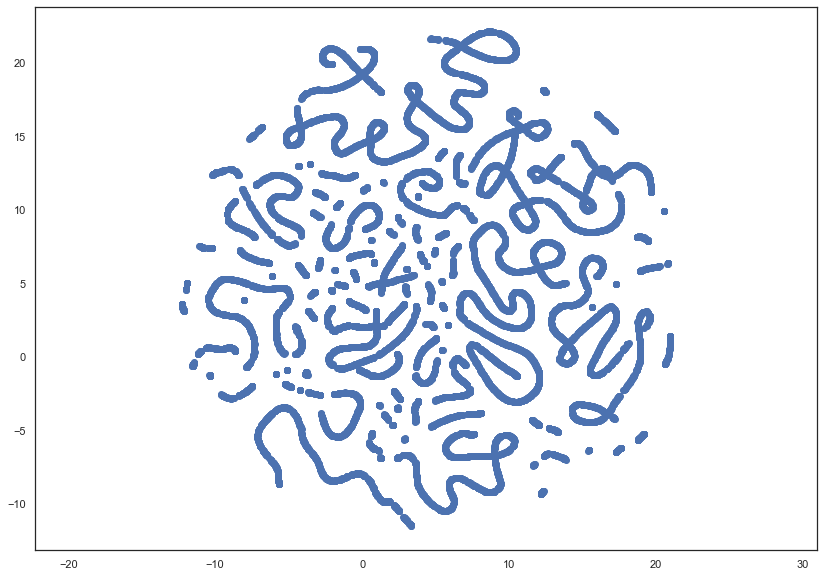

In [7]:
print(embedding.shape)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

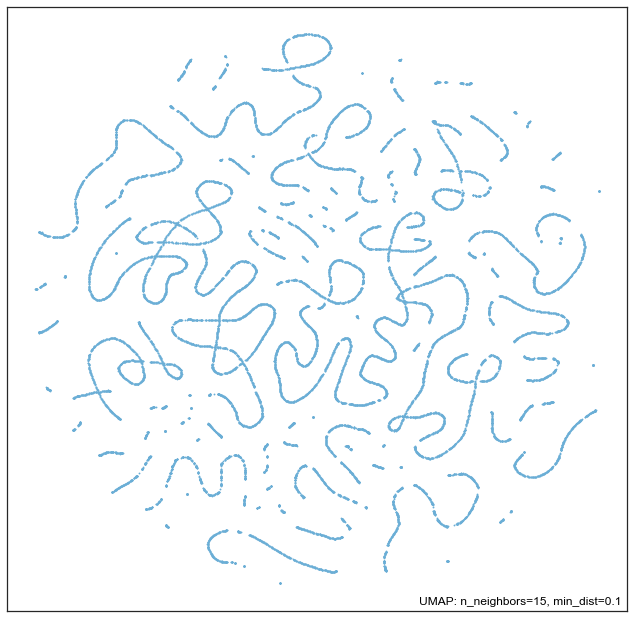

In [8]:
import umap.utils
import umap.plot
umap_model = umap.UMAP().fit(complete_data)
disconnected_points = umap.utils.disconnected_vertices(umap_model)
umap.plot.points(umap_model, subset_points=~disconnected_points)

In [38]:
from sklearn.mixture import GaussianMixture


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

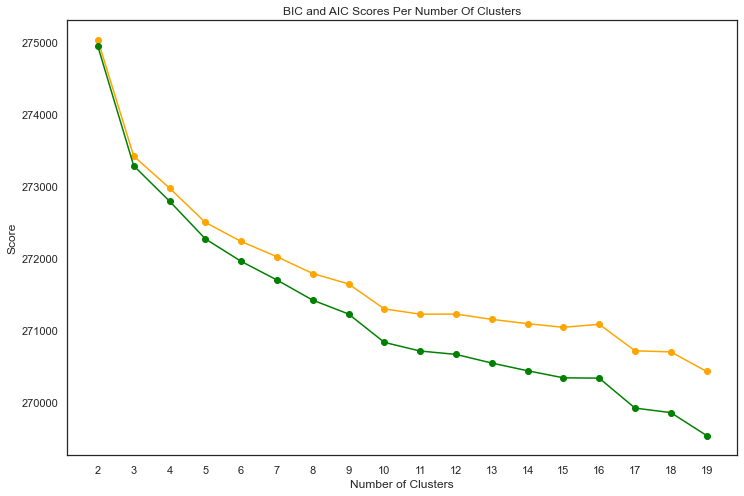

In [41]:
bic_score = []
aic_score = []
n_range = range(2, 20)
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(embedding)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(embedding))
    aic_score.append(gm.aic(embedding))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')


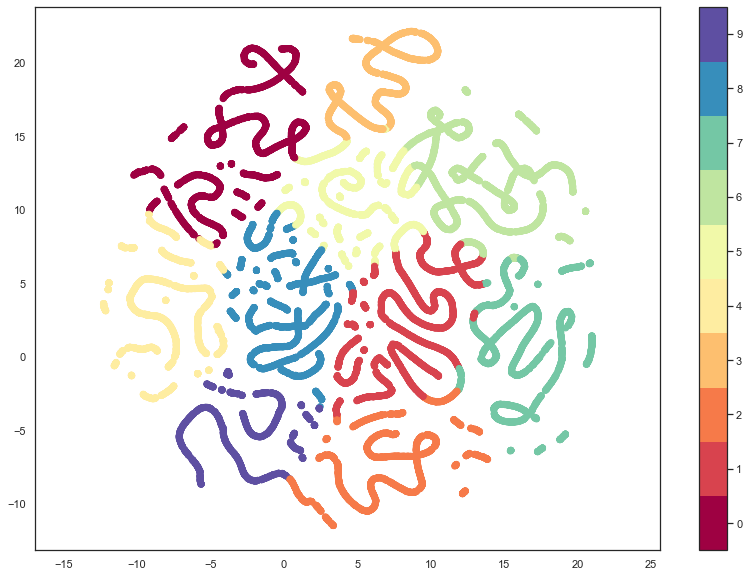

In [80]:
gm = GaussianMixture(n_components=10, 
                     random_state=123, 
                     n_init=10)
gm.fit(embedding)
labels = gm.predict(embedding)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=labels,  cmap='Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(11))
plt.gca().set_aspect('equal', 'datalim')

In [81]:
result_df = pd.DataFrame({"coin": coins, "label": labels})
result_df["coin"] = result_df["coin"].astype(int)


In [84]:
data_total = pd.read_csv('..\\data\\analysis_dataset_w_material.csv', sep=";")
del data_total["Unnamed: 0"]
data_entity = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_data2.csv", sep=";")
data_entity = data_entity[data_entity["Label_Entity"]!="VERBS"]
for i in range(10):
    result_df_sample = result_df[result_df["label"]==i]
    coin_sample = result_df_sample["coin"].to_list()
    data_entity_sample = data_entity[data_entity["id_coin"].isin(coin_sample)]
    data_sample = data_total[data_total["coin"].isin(coin_sample)]
    print("#"*10)
    print(f"Cluster {i}")
    print(data_sample.describe())
    data_entity_agg = data_entity_sample.groupby("Entity")["id_coin"].count().reset_index()
    data_entity_agg = data_entity_agg.sort_values("id_coin", ascending=False)
    print(data_entity_agg.head(20))
    

##########
Cluster 0
               coin      maxdiam      mindiam       weight      enddate  \
count   2376.000000  2376.000000  1331.000000  2376.000000  2376.000000   
mean   22054.359007    18.696814    19.908174     6.935530  -170.094276   
std    15932.186209     6.666679     6.393047     5.543942   247.106836   
min     6571.000000     6.000000     8.000000     0.340000  -550.000000   
25%     7276.750000    13.000000    14.500000     2.420000  -330.000000   
50%     8226.500000    18.000000    20.000000     4.930000  -281.000000   
75%    39212.250000    24.000000    25.000000    10.630000     0.000000   
max    42036.000000    42.000000    42.000000    60.310000   300.000000   

         startdate         axis  material_cat    denom_cat     mint_cat  \
count  2376.000000  1186.000000   2376.000000  2376.000000  2376.000000   
mean   -215.471380     7.807757      0.867003    15.185606    49.910354   
std     260.006121     4.045539      1.330132    17.097530    29.031887   
min

max      37211.000000  
           Entity  id_coin
123          Kopf     1495
137  Lorbeerkranz     1030
28      Brustbild      631
1           Adler      502
49       Dionysos      487
12        Apollon      339
57      Efeukranz      321
274    Weintraube      289
82         Gewand      280
171  Paludamentum      277
184         Pferd      266
14        Artemis      263
185       Pferdes      252
174        Panzer      237
227       Speeren      210
132        Köcher      182
181       Petasos      179
25          Bogen      172
278          Zeus      160
93           Hahn      141
##########
Cluster 7
               coin      maxdiam      mindiam       weight      enddate  \
count   2003.000000  2003.000000  1715.000000  2003.000000  2003.000000   
mean    6095.361957    22.726610    23.471953    10.055512   -24.016975   
std     6167.507490     8.184858     8.060530     9.179276   263.587809   
min      597.000000     6.000000     6.000000     0.310000  -550.000000   
25%     3260.

In [69]:
data_entity.columns

Index(['id_coin', 'id_design', 'design_en', 'design_de', 'side', 'DesignID',
       'Entity', 'Label_Entity'],
      dtype='object')

In [54]:
data_sample0.describe()

,Unnamed: 0,coin,maxdiam,mindiam,weight,enddate,startdate,axis,material_cat,denom_cat,mint_cat,collection_cat
count,1625.000000,1625.000000,1625.000000,1422.000000,1625.000000,1625.000000,1625.000000,1055.000000,1625.000000,1625.000000,1625.000000,1625.000000
mean,20599.113231,11307.354462,20.126172,19.879592,7.048474,-124.270154,-161.395692,7.579147,0.433846,13.748923,47.641231,18477.163692
std,11702.516041,11135.690960,6.502319,6.396083,5.239312,256.020012,267.270143,4.038611,0.528229,15.622580,33.037762,10868.411087
min,60.000000,6363.000000,7.000000,8.000000,0.450000,-500.000000,-540.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,10299.000000,6811.000000,15.000000,14.000000,2.590000,-336.000000,-365.000000,5.000000,0.000000,0.000000,15.000000,9030.000000
50%,20619.000000,7309.000000,20.000000,20.000000,6.070000,-215.000000,-286.000000,7.000000,0.000000,4.000000,52.000000,18418.000000
75%,30305.000000,7940.000000,25.000000,25.000000,10.410000,210.000000,193.000000,12.000000,1.000000,25.000000,70.000000,28039.000000
max,41052.000000,41902.000000,42.000000,42.000000,60.310000,300.000000,253.000000,12.000000,4.000000,51.000000,115.000000,37215.000000


In [64]:
data_entity_agg = data_entity_sample0.groupby("Entity")["id_coin"].count().reset_index()
data_entity_agg = data_entity_agg.sort_values("id_coin", ascending=False)
data_entity_agg.head(20)

,Entity,id_coin
117,Kopf,1095
134,Lorbeerkranz,475
26,Brustbild,391
308,haltend,322
165,Paludamentum,313
297,erhoben,290
328,stehend,284
85,Greif,276
168,Panzer,275
97,Herakles,239


In [7]:
#try to transform sparse entity data only:
entity_dummys = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_dummys.csv", sep=";")
entity_dummys.columns
del entity_dummys["Unnamed: 0"]
coin_mapping = entity_dummys["id_coin"].to_list()
del entity_dummys["id_coin"]
entity_dummys.shape

(28995, 570)

In [9]:
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, init='random', low_memory=True).fit(entity_dummys)

Wall time: 53.1 s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

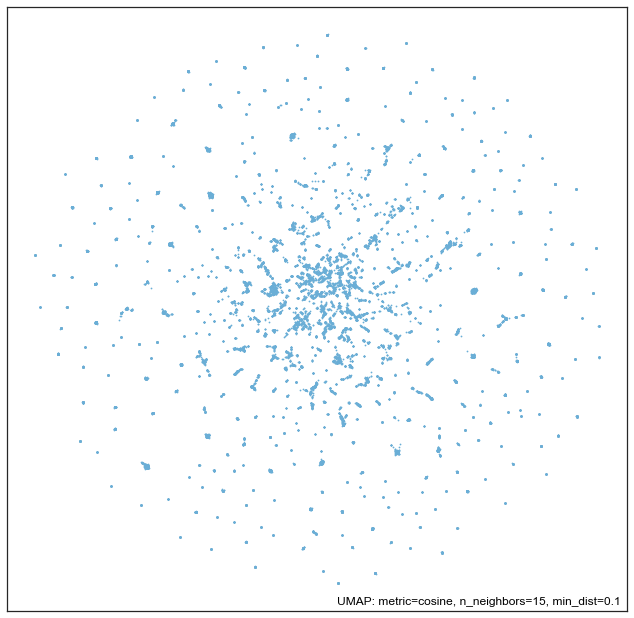

In [10]:
umap.plot.points(mapper)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

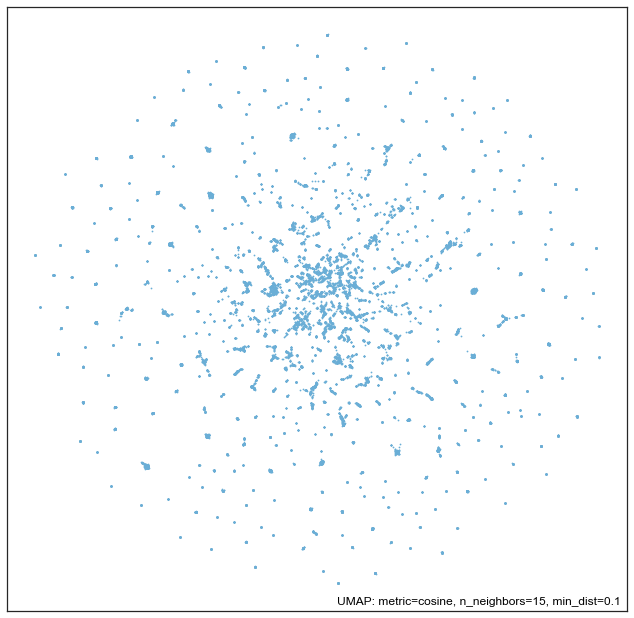

In [16]:
#disconnected vertexes
disconnected_points = umap.utils.disconnected_vertices(mapper)
umap.plot.points(mapper, subset_points=~disconnected_points)

In [ ]:

%%time
mapper = umap.UMAP(metric='cosine', random_state=42, init='random').fit(complete_data)